# BERT Model Training

 This part will demonstrate how to train and use the BERT pre-trained language model for sentiment analysis for AI news. 

## About BERT

<div style="text-align: justify">
BERT, which stands for Bidirectional Encoder Representations from Transformers, is built based on transformers, a deep learning model which relates each output to every input element by a weighting dynamically computed based on their associations. It was introduced in October 2018 by researchers at Google. One advantage of using the BERT is that it is pretrained using text from BookCorpus and English Wikipedia and can be fine-tuned with question-and-answer datasets, such that our workload is greatly reduced and the model can be customized for the context of AI news in our project.</div>

## Setup

In [8]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

# AdamW optimizer from tensorflow/models.
!pip install "tf-models-official==2.13.*"

## Modules

In [1]:
import os  # For interacting with the operating system
import shutil  # For high-level operations on files and directories
import random

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR') # Set TensorFlow logging level to ERROR

2024-04-23 16:37:37.457257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preparation

### Read Preprocessed Dataset

<div style="text-align: justify">
In this step, we need to read the preprocessed data from a text file. To ensure convenience in later steps, we need to transform the data into a list that stores lists of <code>[sentence, label]</code>.</div>

In [62]:
import re

data = []
# Read data from the file
with open('combined_result.txt', 'r') as file:
    for line in file:
        # Remove leading and trailing whitespace and newline character
        line = line.strip()
        # Remove the square brackets
        line = line.strip("[]")
        # Extract the sentence and label
        match = re.match(r'^(.+?),\s*(\d+)$', line)
        if match:
            # Find the index of the last comma in the line
            last_comma_index = line.rindex(',')
            sentence = line[:last_comma_index].strip()
            label = int(line[last_comma_index + 1:].strip())
            data.append([sentence, label])

Then, we have to create a labeled `tf.data.Dataset` and split it into training set, validation set and test set.

In [63]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

# Convert the 'data' list to NumPy arrays
data = np.array(data)

# Split the data into train and test sets (80% train, 20% test)
train, test, train_labels, test_labels = train_test_split(
    data[:, 0], data[:, 1], test_size=0.2, random_state=seed)

# Split the train data further to create a validation set (20% of train)
train, val, train_labels, val_labels = train_test_split(
    train, train_labels, test_size=0.2, random_state=seed)

# Convert labels to integers
train_labels = train_labels.astype(int)
val_labels = val_labels.astype(int)
test_labels = test_labels.astype(int)

# Create tf.data.Dataset objects for train, validation, and test sets
train_ds = tf.data.Dataset.from_tensor_slices((train, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test, test_labels))

# Shuffle and batch the datasets
train_ds = train_ds.shuffle(len(train)).batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Cache and prefetch the datasets
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = ['negative', 'neutral', 'positive']

Let's take a look at a few samples.

In [65]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Sentence: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Sentence: b'Average yearly return: +27% https://t.co/npXwy7CHFR'
Label : 2 (positive)
Sentence: b'"All YIT Capital Markets Day materials will be available on the company \'s Internet site at www.yitgroup.com/investors at 10:30 on September 26 ."'
Label : 1 (neutral)
Sentence: b"'Via the move , the company aims annual savings of some EUR3m , the main part of which are expected to be realized this year .'"
Label : 2 (positive)


2024-04-20 03:57:14.305530: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading Models from TensorFlow Hub

TensorFlow Hub provides various kinds of BERT which can tackle different needs. For example:
- [Small BERT](https://www.kaggle.com/models?id=199%2C16%2C113%2C258%2C19%2C27%2C91%2C191%2C17%2C244%2C100%2C274%2C176&tfhub-redirect=true) : Fewer Transformer blocks, which allows users to strike a balance between speed, size and quality.
- [ALBERT](https://www.kaggle.com/models?id=16%2C17&tfhub-redirect=true) : Reduces model size by sharing parameters between layers.
- [Electra](https://www.kaggle.com/models?id=258%2C244&tfhub-redirect=true) : Shares the identical structure as BERT, but undergoes pre-training as a discriminator within a configuration that mimics a Generative Adversarial Network.

<div style="text-align: justify">
Here, we have selected Small BERT due to its compact size and efficiency. As we only have limited time, Small BERT offers a good balance between model performance and computational resources. It allows for faster training and inference while still capturing essential language representations.</div>

In [66]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Model Training

In [76]:
def build_classifier_model():
  # Define input layer for text
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  # Preprocessing layer using TensorFlow Hub
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  # BERT encoder layer using TensorFlow Hub
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  # Extract pooled output from BERT
  net = outputs['pooled_output']
  # Apply dropout for regularization
  net = tf.keras.layers.Dropout(0.1)(net)
  # Final classification layer
  net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)

  return tf.keras.Model(text_input, net)

### Loss Function

Since this is a classification problem with 3 classes, we will use `losses.SparseCategoricalCrossentropy` loss function.

In [68]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

### Optimizer

<div style="text-align: justify">For the fine-tuning process, we will utilize the Adam optimizer, which was originally employed during the training of BERT. This optimizer is responsible for minimizing the loss associated with predictions, while also performing weight decay for regularization purposes.
<br><br>
Regarding the learning rate (<code>init_lr</code>), we will adopt the same schedule employed during BERT pre-training. This schedule involves a linear decay of an initial learning rate, preceded by a linear warm-up phase that spans the first 10% of the training steps (<code>num_warmup_steps</code>). According to the <a href="https://arxiv.org/pdf/1810.04805.pdf">BERT paper</a>, a smaller initial learning rate is preferable for fine-tuning, with potential options being 5e-5, 3e-5, or 2e-5.</div>

In [77]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT Model and Training

In [78]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

2024-04-20 03:59:55.772093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [79]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
140/140 [==============================] - 374s 3s/step - loss: 0.8845 - sparse_categorical_accuracy: 0.5955 - val_loss: 0.6719 - val_sparse_categorical_accuracy: 0.6962
Epoch 2/5
140/140 [==============================] - 384s 3s/step - loss: 0.6236 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.5803 - val_sparse_categorical_accuracy: 0.7534
Epoch 3/5
140/140 [==============================] - 367s 3s/step - loss: 0.4927 - sparse_categorical_accuracy: 0.8055 - val_loss: 0.5480 - val_sparse_categorical_accuracy: 0.7784
Epoch 4/5
140/140 [==============================] - 367s 3s/step - loss: 0.4100 - sparse_categorical_accuracy: 0.8386 - val_loss: 0.5633 - val_sparse_categorical_accuracy: 0.7873
Epoch 5/5
140/140 [==============================] - 368s 3s/step - loss: 0.3589 - sparse_categorical_accuracy: 0.8567 - val_loss: 0.5744 - val_sparse_categorical_accuracy: 0.7775


### Evaluate the Model with Test Set

In [80]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

44/44 [==============================] - 32s 733ms/step - loss: 0.5302 - sparse_categorical_accuracy: 0.7847
Loss: 0.5302212238311768
Accuracy: 0.7846924066543579


### Plot the Accuracy and Loss over Time

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


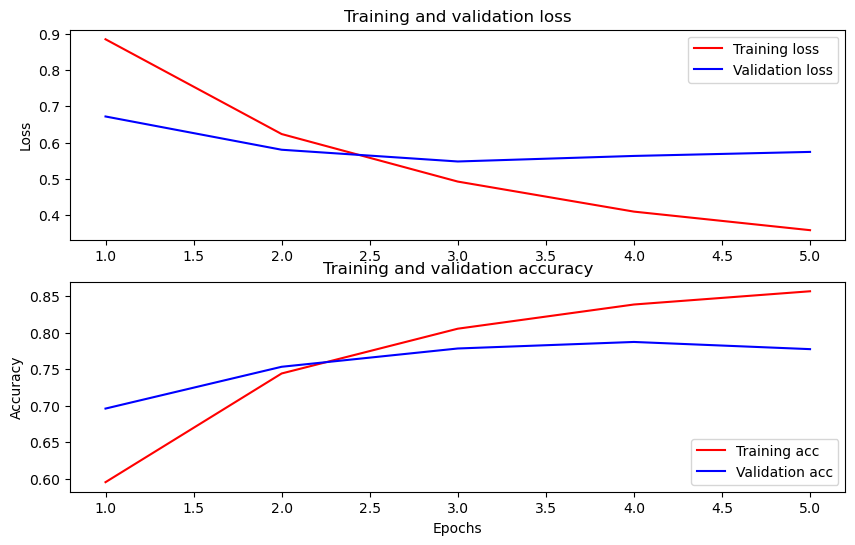

In [81]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export the Model

After we have fine tuned the BERT model, we can now export and save it for later use.

In [82]:
dataset_name = 'sentiment'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

## Reload our Model

In [2]:
reloaded_model = tf.saved_model.load('sentiment_bert')

<div style="text-align: justify">Let's define a function that create a <code>pandas dataframe</code> to display the output of our model, the output will be displayed in the form of <code>[sentence, logit, prediction, sentiment score]</code>.</div>

In [3]:
def print_result(inputs):
    # Logit
    logits = tf.nn.softmax(reloaded_model(tf.constant(examples))).numpy().tolist()
    round_logits = [[round(value, 6) for value in sublist] for sublist in logits]
    # Prediction
    predict = tf.argmax(logits, axis=1)
    label_mapping = {0: "negative", 1: "neutral", 2: "positive"}
    labels = [label_mapping[label] for label in predict.numpy()]
    # Sentiment score
    class_score = [0,5,10]
    sentiments = ["{:.6f}".format(np.dot(i, class_score)) for i in logits]
    # Create a data frame
    df = pd.DataFrame({'Sentence':inputs,'Logit':round_logits,'Prediction':labels,\
                       'Sentiment Score':sentiments})
    pd.set_option('display.max_colwidth', None)  
    return df

Here we try on few examples:

In [6]:
examples = [
    'Google announced a slew of AI enhancements designed to help customers take advantage of the Gemini large language model (LLM) and improve productivity across the platform. ',\
    'OpenAI’s Sam Altman is funding a green-energy moonshot as AI’s power demands grow to ‘insatiable’ levels',\
    'AI is threatening Americans’ jobs. Could guaranteed income provide a safety net?',\
    'Could Elon Musk’s Release of the Chatbot Code Help You Make Money With AI?',\
    'Why "dark AI" is a top cybersecurity concern for 2024'\
]

print_result(examples)

,Sentence,Logit,Prediction,Sentiment Score
0,Google announced a slew of AI enhancements designed to help customers take advantage of the Gemini large language model (LLM) and improve productivity across the platform.,"[0.003741, 0.027686, 0.968573]",positive,9.824157
1,OpenAI’s Sam Altman is funding a green-energy moonshot as AI’s power demands grow to ‘insatiable’ levels,"[0.011034, 0.006165, 0.9828]",positive,9.858830
2,AI is threatening Americans’ jobs. Could guaranteed income provide a safety net?,"[0.965994, 0.014609, 0.019397]",negative,0.267014
3,Could Elon Musk’s Release of the Chatbot Code Help You Make Money With AI?,"[0.431988, 0.449198, 0.118814]",neutral,3.434129
4,"Why ""dark AI"" is a top cybersecurity concern for 2024","[0.94088, 0.010882, 0.048238]",negative,0.536792
